# ML part

In [1]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn import preprocessing
import numpy as np 
import pandas as pd

In [2]:
!pip3 install imblearn

In [3]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [8]:
columns = ['angle', 'eta', 'pt', 'eta_sum', "pl", "id"]
DATA = pd.read_csv("data/HNL_neutrino_in_accp.csv")[columns]

In [9]:
DATA

,angle,eta,pt,eta_sum,pl,id
0,0.028562,8.204541,2.108073,4.196049,69.996793,HNL
1,0.047040,8.633979,0.543982,5.039676,41.999044,HNL
2,0.066814,8.189327,0.103869,6.338688,29.397594,HNL
3,0.115996,7.331676,0.363074,4.850221,23.193333,HNL
4,0.032009,8.695774,1.332833,4.533561,62.029203,HNL
...,...,...,...,...,...,...
6155,0.033853,8.344044,2.106025,4.233403,72.591500,nu
6156,0.082426,8.229011,1.098946,4.250610,38.536700,nu
6157,0.041720,8.608324,1.969009,4.451474,84.412940,nu
6158,0.131722,6.786665,1.502157,3.792704,33.313090,nu


In [10]:
X, y = DATA[columns[:-1]], DATA['id']

In [13]:
X

,angle,eta,pt,eta_sum,pl
0,0.028562,8.204541,2.108073,4.196049,69.996793
1,0.047040,8.633979,0.543982,5.039676,41.999044
2,0.066814,8.189327,0.103869,6.338688,29.397594
3,0.115996,7.331676,0.363074,4.850221,23.193333
4,0.032009,8.695774,1.332833,4.533561,62.029203
...,...,...,...,...,...
6155,0.033853,8.344044,2.106025,4.233403,72.591500
6156,0.082426,8.229011,1.098946,4.250610,38.536700
6157,0.041720,8.608324,1.969009,4.451474,84.412940
6158,0.131722,6.786665,1.502157,3.792704,33.313090


## Preprocessing

In [14]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.to_numpy(), random_state=42)

In [15]:
def bootstrap_metric(x, 
                     y,
                     metric_fn,
                     samples_cnt = 100,
                     alpha = 0.05,
                     random_state = 42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
        if it%10 == 0:
            print(it, "...")
    
    return b_metric

## Choose model

In [16]:
model = BalancedRandomForestClassifier()

## Estimate model

In [17]:
from sklearn import datasets, metrics, model_selection, svm
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sum(y_pred == y_test)/len(y_test)

0.825974025974026

In [18]:
from sklearn.metrics import matthews_corrcoef
alpha = 0.05

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cor = matthews_corrcoef(y_test, y_pred)
boot_mat_score = bootstrap_metric(y_test, y_pred, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y) , alpha = 0.1)
print("Model: {0}".format(model), " \t Matthews score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))

0 ...
10 ...
20 ...
30 ...
40 ...
50 ...
60 ...
70 ...
80 ...
90 ...
Model: BalancedRandomForestClassifier()  	 Matthews score:  [0.56025783 0.65174049]


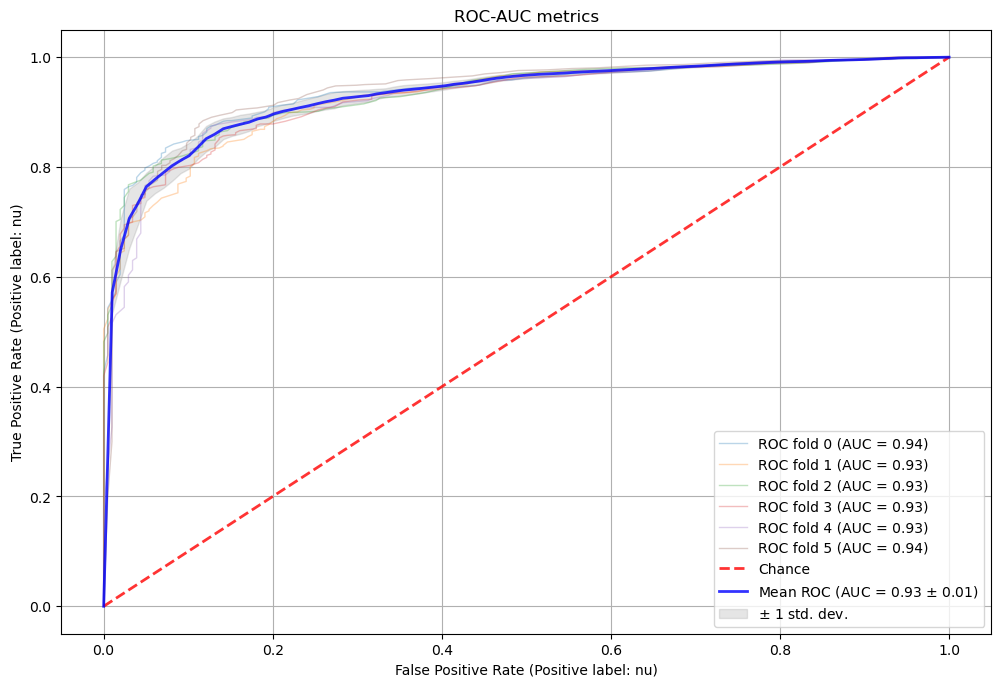

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X, y = X_scaled, y.to_numpy()

fig, ax = plt.subplots(figsize = (12,8), dpi = 100)
plt.grid()
for i, (train, test) in enumerate(cv.split(X,y)):
    model.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC-AUC metrics",
)
ax.legend(loc="lower right")
plt.show()

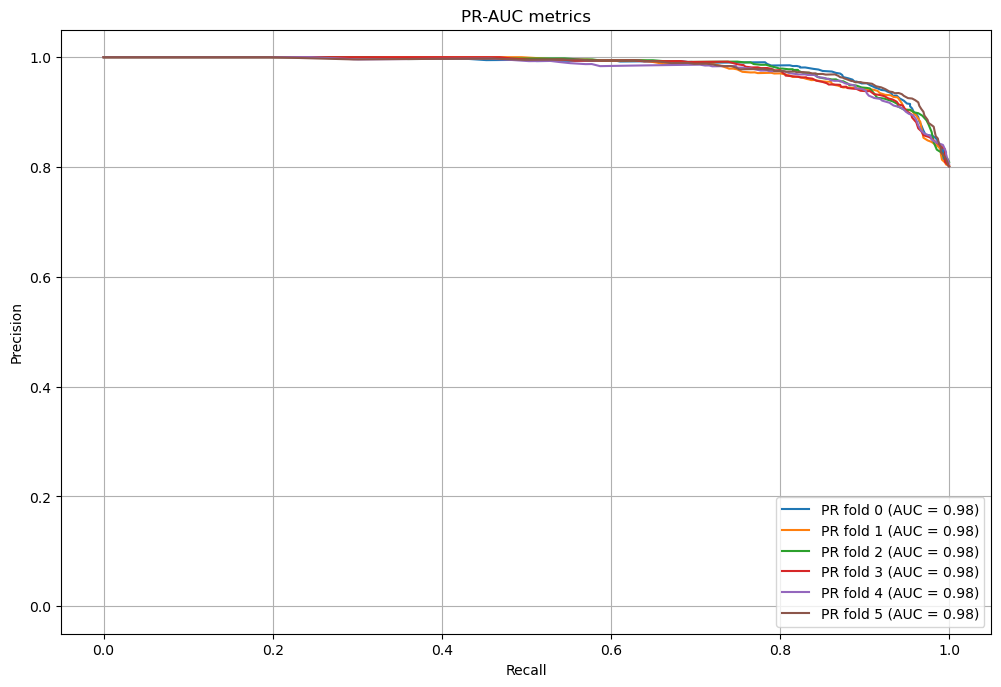

In [24]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize = (12,8), dpi = 100)
plt.grid()
for i, (train, test) in enumerate(cv.split(X,y)):
    model.fit(X[train], y[train])
    pred_proba = model.predict_proba(X[test])
    precision, recall, _ = precision_recall_curve(y[test], pred_proba[:, 1], pos_label = 'nu')
    auc_0 = auc(recall, precision)
    aucs.append(auc_0)
    ax.plot(recall, precision, label="PR fold {}".format(i) + " (AUC = %0.2f)" % auc_0)  
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PR-AUC metrics",
)
ax.legend(loc="lower right")
plt.show()